# K plus proches voisins supervised learning methode

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

from sklearn.base import BaseEstimator, MetaEstimatorMixin

In [5]:
cls = KNeighborsClassifier(n_neighbors=3)

In [6]:
Xy = pd.read_csv("data/Synth1-2000.csv")

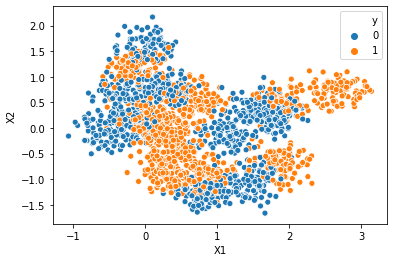

In [13]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]
plot_clustering(X, y)
plt.show()

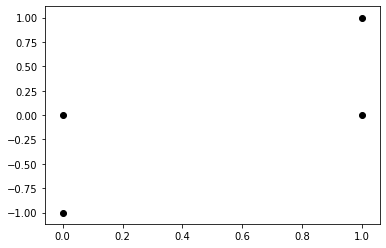

In [19]:
Y = np.array([[0, 0], [0, -1], [1, 0], [1, 1]])
plt.scatter(*Y.T, color="k")

In [25]:
cls = KNeighborsClassifier(n_neighbors=5)
cls.fit(X, y)
p = np.array([[0, 0], [0, -1], [1, 0], [1, 1]])
labels = cls.predict(p)
labels

array([0, 1, 0, 1])

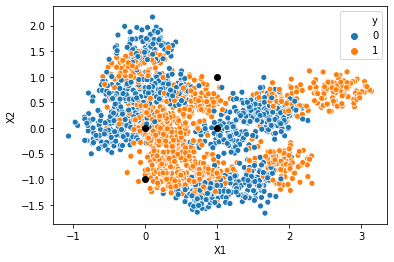

In [26]:
plot_clustering(X, y)
plt.scatter(*Y.T, color="k")
plt.show()

In [12]:
def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """
    Utilise `sns.scatterplot` en appliquant d'abord une ACP si besoin
    pour réduire la dimension.
    """

    # Select columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    sp_kwargs = {}
    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        sp_kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        sp_kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **sp_kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.
    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_facecolor().ravel()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], 180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca


def add_decision_boundary(model, levels=None, resolution=1000, ax=None, label=None):
    """Trace une frontière de décision sur une figure existante.

    La fonction utilise `model` pour prédire un score ou une classe
    sur une grille de taille `resolution`x`resolution`. Une (ou
    plusieurs frontières) sont ensuite tracées d'après le paramètre
    `levels` qui fixe la valeur des lignes de niveaux recherchées.

    """

    if ax is None:
        ax = plt.gca()


    if isinstance(model, MetaEstimatorMixin):
        return add_decision_boundary(model.best_estimator_, levels=levels, resolution=resolution, ax=ax, label=label)

    elif callable(model):
        if levels is None:
            levels = [0]
        def predict(X):
            return model(X)

    elif isinstance(model, BaseEstimator):
        n_classes = len(model.classes_)
        if "decision_function" in dir(model):
            if n_classes == 2:
                if levels is None:
                    levels = [0]
                def predict(X):
                    return model.decision_function(X)
        else:
            levels = np.arange(n_classes - 1) + .5
            def predict(X):
                pred = model.predict(X)
                _, idxs = np.unique(pred, return_inverse=True)
                return idxs
    else:
        raise Exception("Modèle pas supporté")


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = predict(xy).reshape(XX.shape)

    scout, = ax.plot([], [], linestyle="dashed")
    orig_color = scout.get_color()
    sns.lineplot([0], [0], label=label, ax=ax, color=orig_color, linestyle="dashed")

    ax.contour(
        XX,
        YY,
        Z,
        levels=levels,
        colors=orig_color,
        linestyles="dashed",
        antialiased=True,
    )
